In [1]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")  # silence LAL warnings
import time
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as aconst
import scipy.constants as const
from scipy.interpolate import interp1d
from scipy.optimize import minimize
from pesummary.gw.conversions.mass import component_masses_from_mtotal_q
from pycbc.types.timeseries import TimeSeries
from pycbc.filter import sigmasq, match
from pycbc import psd as psd_func
from pycbc.waveform import taper_timeseries
from pyseobnr.generate_waveform import GenerateWaveform, generate_modes_opt
from gw_eccentricity import measure_eccentricity
from simple_pe.waveforms import generate_eccentric_waveform

import logging
_logger = logging.getLogger('PESummary')
_logger.setLevel(logging.CRITICAL + 10)
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

/home/ben.patterson/.conda/envs/igwn_eccentric_new/lib/python3.10/site-packages/pykerr/qnm.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


lal.MSUN_SI != Msun


In [2]:
def gen_seob_wf(
    m_total, q, ecc, s1z, s2z, f_start, s_rate,
    rel_anomaly=0, distance=1, inclination=0, phase=0, modes=None
):
    """
    Wrapper function to generate SEOBNRv5EHM waveform.

    :param m_total: total mass
    :type m_total: float, required
    :param q: inverted mass ratio
    :type q: float, required
    :param ecc: eccentricity
    :type ecc: float, required
    :param s1z: z component of primary spin
    :type s1z: float, required
    :param s2z: z component of secondary spin
    :type s2z: float, required
    :param f_start: starting orbit averaged frequency of 22 mode
    :type f_start: float, required
    :param s_rate: sample_rate
    :type s_rate: integer, required
    :param rel_anomaly: relativistic anomaly
    :type rel_anomaly: float, optional
    :param distance: distance
    :type distance: float, optional
    :param inclination: inclination
    :type inclination: float, optional
    :param phase: phase
    :type phase: float, optional
    :param modes: modes to include
    :param modes: list of tuples, optional

    :return h: waveform
    :rtype h: TimeSeries object
    """

    # Which modes to include
    if modes is None:
        modes = [(2, 2), (2, 1), (3, 3), (3, 2), (4, 4)]
    settings = {'return_modes': modes}

    # Convert masses
    m1, m2 = component_masses_from_mtotal_q(m_total, 1/q)

    # Parameters of waveform
    params_dict = {
        "mass1": m1,
        "mass2": m2,
        "spin1z": s1z,
        "spin2z": s2z,
        "deltaT": 1 / s_rate,
        "f22_start": f_start,
        "phi_ref": phase,
        "distance": distance,
        "inclination": inclination,
        "approximant": "SEOBNRv5EHM",
        "eccentricity": ecc,
        "rel_anomaly": rel_anomaly,
        "settings": settings
    }

    # Generate waveform
    wfm_gen = GenerateWaveform(params_dict)
    hp, hc = wfm_gen.generate_td_polarizations()
    hp = TimeSeries(hp.data.data, hp.deltaT, hp.epoch)
    hc = TimeSeries(hc.data.data, hc.deltaT, hc.epoch)
    
    return hp - 1j*hc

/home/ben.patterson/.conda/envs/igwn_eccentric_new/lib/python3.10/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/ben.patterson/.conda/envs/igwn_eccentric_new/lib/python3.10/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


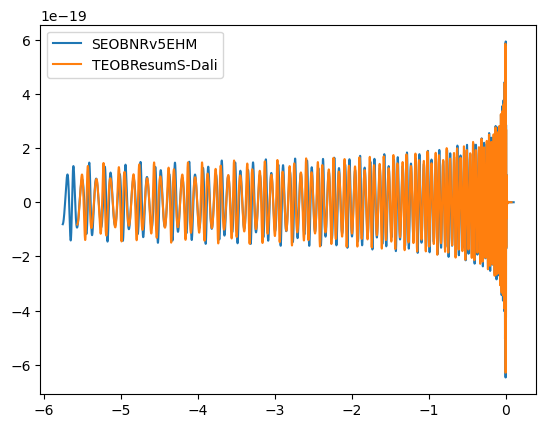

In [3]:
m_total = 60
q = 2
e = 0.2
s1z = 0
s2z = 0
f_start = 10
s_rate = 4096
modes = [(2, 2)]

seob = gen_seob_wf(m_total, q, e, s1z, s2z, f_start, s_rate, modes=modes, rel_anomaly=np.pi)
teob_p, teob_c = generate_eccentric_waveform(m_total, q, e, s1z, s2z, f_start, s_rate, mode_array=modes, taper=False, to_fs=False)
teob = teob_p - 1j*teob_c

plt.plot(seob.sample_times, seob, label='SEOBNRv5EHM')
plt.plot(teob.sample_times, teob, label='TEOBResumS-Dali')
plt.legend()

In [4]:
teob_data_dict = {'t': teob.sample_times, 'hlm': {(2, 2): teob.data.data}}
seob_data_dict = {'t': seob.sample_times, 'hlm': {(2, 2): seob.data.data}}

teob_e_gw_dict = measure_eccentricity(tref_in=-5, method='AmplitudeFits', dataDict=teob_data_dict)
print(teob_e_gw_dict)
seob_e_gw_dict = measure_eccentricity(tref_in=-5, method='AmplitudeFits', dataDict=seob_data_dict)
print(seob_e_gw_dict)

{'eccentricity': 0.19426907287157835, 'mean_anomaly': 6.2694815119066085, 'tref_out': -5, 'gwecc_object': <gw_eccentricity.eccDefinitionUsingAmplitudeFits.eccDefinitionUsingAmplitudeFits object at 0x7fe61e0b31f0>}
{'eccentricity': 0.1906502774490988, 'mean_anomaly': 5.151948598595787, 'tref_out': -5, 'gwecc_object': <gw_eccentricity.eccDefinitionUsingAmplitudeFits.eccDefinitionUsingAmplitudeFits object at 0x7fe61e7bbb50>}


In [37]:
def compare_e_gw(ecc):
    print(f'\rtrying {ecc[0]:.6f}', end='')
    seob_trial = gen_seob_wf(m_total, q, ecc[0], s1z, s2z, f_start, s_rate, modes=modes, rel_anomaly=np.pi)
    seob_data_dict = {'t': seob_trial.sample_times, 'hlm': {(2, 2): seob_trial.data.data}}
    try:
        seob_e_gw_dict = measure_eccentricity(tref_in=-4, method='AmplitudeFits', dataDict=seob_data_dict)
    except:
        return 1
    e_gw_diff = np.abs(teob_e_gw_dict['eccentricity']-seob_e_gw_dict['eccentricity'])
    return e_gw_diff

result = minimize(compare_e_gw, e, bounds=[(0, 0.5)], method='Nelder-Mead')
print(f'\nfound {result["x"][0]:.6f}')

trying 0.218828
found 0.218828


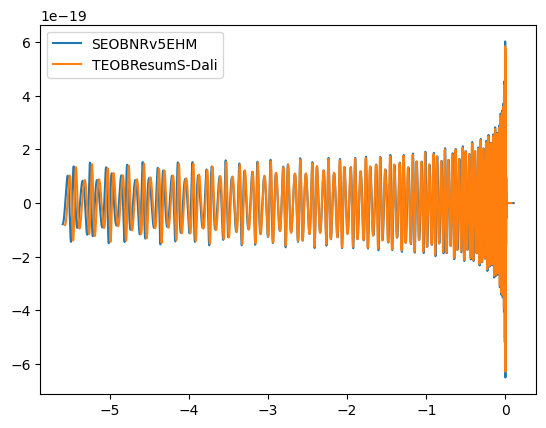

In [38]:
new_seob = gen_seob_wf(m_total, q, result['x'][0], s1z, s2z, f_start, s_rate, modes=modes, rel_anomaly=np.pi)

plt.plot(new_seob.sample_times, new_seob, label='SEOBNRv5EHM')
plt.plot(teob.sample_times, teob, label='TEOBResumS-Dali')
plt.legend()

Can get very close with e_gw, but it strongly depends on reference time we measure eccentricity at - perhaps due to a mean anomaly effect?